In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [4]:
torch.__version__

'2.7.1'

In [8]:
#use GPU on mac
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Use GPU to train
- Put the model onto GPU
- Put the training data of each batch onto GPU

In this project, we will use some stored data from torchvision.  
torchvision has some default datasets.

`transform.ToTensor`: convert data to tensor, values are between 0 and 1, put channel to the first dimension

In [48]:
from torchvision import datasets, transforms
#transform is dedicated for data enforcement and preprocessing.

In [49]:
transformation = transforms.Compose([transforms.ToTensor()])
tran_ds = datasets.MNIST('./data', train = True, transform=transformation, download=True) # the directory is where you download the data to

In [50]:
test_ds = datasets.MNIST('./data', train = False, transform=transformation, download=True) # the directory is where you download the data to

The data is downaloaded to folder './data'

### Convert the datat to DataLoad

In [51]:
train_dl = torch.utils.data.DataLoader(tran_ds, batch_size = 64, shuffle = True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 256)

In [52]:
next(iter(train_dl))[0].shape
#64 in batch, 1 channel, 28*28 picture

torch.Size([64, 1, 28, 28])

In [53]:
next(iter(train_dl))[1].shape

torch.Size([64])

Illustrate some examples.

In [54]:
img = np.squeeze(next(iter(train_dl))[0][0])

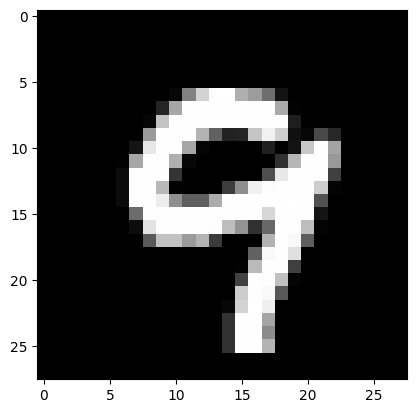

In [55]:
plt.imshow(img, cmap = 'gray')

## Create the model

In [88]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3) #out 64, 32, 26, 26
        self.pool1 = nn.MaxPool2d(2) #out 64, 32, 13, 13
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) #out 64, 64, 11, 11
        #another layer of pooling: out 64, 64, 5, 5
        
        self.linear1 = nn.Linear(64*5*5, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, input):
        x = F.relu(self.conv1(input))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        #flatten
        x = x.view(-1, 64*5*5)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [89]:
model = Model1()
model.to(device)

Model1(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=1600, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
)

In [90]:
loss_fn = torch.nn.CrossEntropyLoss()

In [91]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [92]:
def fit (epoch, model, train_loader, test_loader):
    correct = 0
    total = 0
    running_loss = 0

    for x, y in train_loader:
        #put the data to GPU
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim = 1)
            correct += (y_pred==y).sum().item()
            total += y.size(0)
            running_loss +=loss.item()
            
    epoch_loss = running_loss/len(train_loader.dataset)
    epoch_acc = correct/total
    
    #test
    test_correct = 0
    test_running_loss = 0
    test_total = 0

    with torch.no_grad():
        for x, y in train_loader:
            #put the data to GPU
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim = 1)
            test_correct += (y_pred==y).sum().item()
            test_total += y.size(0)
            test_running_loss +=loss.item()
    
    test_epoch_loss = test_running_loss/len(test_loader.dataset)
    test_epoch_acc = test_correct/test_total

    print(f'Epoch: {epoch}, loss:{round(epoch_loss, 3)}, accuracy: {round(epoch_acc, 3)}, test_loss: {round(test_epoch_loss, 3)}, test_accuracy: {round(test_epoch_acc, 3)}')
    
    return  epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc  
                
            

In [93]:
epochs = 20
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)

Epoch: 0, loss:0.003, accuracy: 0.948, test_loss: 0.005, test_accuracy: 0.983
Epoch: 1, loss:0.001, accuracy: 0.983, test_loss: 0.004, test_accuracy: 0.988
Epoch: 2, loss:0.001, accuracy: 0.988, test_loss: 0.002, test_accuracy: 0.992
Epoch: 3, loss:0.0, accuracy: 0.991, test_loss: 0.002, test_accuracy: 0.994
Epoch: 4, loss:0.0, accuracy: 0.994, test_loss: 0.001, test_accuracy: 0.997
Epoch: 5, loss:0.0, accuracy: 0.995, test_loss: 0.001, test_accuracy: 0.996
Epoch: 6, loss:0.0, accuracy: 0.996, test_loss: 0.001, test_accuracy: 0.997
Epoch: 7, loss:0.0, accuracy: 0.997, test_loss: 0.001, test_accuracy: 0.996
Epoch: 8, loss:0.0, accuracy: 0.997, test_loss: 0.001, test_accuracy: 0.998
Epoch: 9, loss:0.0, accuracy: 0.997, test_loss: 0.001, test_accuracy: 0.998
Epoch: 10, loss:0.0, accuracy: 0.998, test_loss: 0.0, test_accuracy: 0.999
Epoch: 11, loss:0.0, accuracy: 0.998, test_loss: 0.001, test_accuracy: 0.997
Epoch: 12, loss:0.0, accuracy: 0.998, test_loss: 0.0, test_accuracy: 0.998
Epoch: 